<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
pillow==7.1.2
monai==0.9.1
tensorboard==2.8.0

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 19.1 MB 455 kB/s 
     |████████████████████████████████| 990 kB 32.0 MB/s 
     |████████████████████████████████| 62 kB 641 kB/s 
     |████████████████████████████████| 146 kB 57.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1


In [3]:
import os
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
from torchvision import models
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
# from torch.utils.tensorboard import SummaryWriter

## Specify global parameters

In [4]:
data_dir = 'data'
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

In [5]:
np.random.seed(random_seed)

## Download data from MLHUB


In [6]:
collection_name = 'ref_agrifieldnet_competition_v1'

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [7]:
if not os.path.exists(data_dir):
  os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

  dataset = Dataset.fetch(collection_name)
  dataset.download(output_dir=data_dir)
  for fn in os.listdir(data_dir):
    with tarfile.open(os.path.join(data_dir, fn)) as f:
      f.extractall(data_dir + '/') 
    os.remove(os.path.join(data_dir, fn))
else:
  print("Dataset already exists")

MLHub API Key: ··········


  0%|          | 0/0.5 [00:00<?, ?M/s]

  0%|          | 0/324.3 [00:00<?, ?M/s]

  0%|          | 0/1.3 [00:00<?, ?M/s]

## Prepare Training data


### Create training dataframe

In [8]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [9]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,8b528,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,19944,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,dc19d,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,393fe,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,ceac6,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...



## Extract field-crop data

In [10]:
def extract_field_crop_data(data):
  field_ids = []
  crop_type = []
  field_area = []
  field_max_dim = []
  field_center_x = []
  field_center_y = []
  label_paths = []
  field_paths = []
  source_paths = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]
      with rasterio.open(data['label_path'].iloc[i]) as src:
          crop_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          crop_type.append(np.unique(crop_data[ind])[-1])
          field_area.append(len(ind[0]))
          field_max_dim.append(np.max(np.array(ind).max(1) - np.array(ind).min(1) + 1))
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          label_paths.append(data['label_path'].iloc[i])
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, crop_type, field_area, 
                              field_max_dim, field_center_x, 
                              field_center_y]).transpose(),
                    columns=['field_id', 'crop_type', 'field_area', 
                            'field_max_dim', 'center_x', 'center_y'])
  df['label_path'] = label_paths
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [11]:
df = extract_field_crop_data(train_data)

100%|██████████| 1165/1165 [00:07<00:00, 163.57it/s]


In [12]:
maxdim = df['field_max_dim'].max()
maxdim

54.0

In [13]:
size = 64

### Split the data into train and validation

In [14]:
val_fraction = 0.2

In [15]:
np.random.seed(random_seed)
df_train = []
df_val = []
for crop in df['crop_type'].unique():
    cur_df = df[df['crop_type'] == crop].reset_index(drop=True)
    unique_field_ids = cur_df['field_id'].unique()
    ind = np.arange(len(unique_field_ids))
    np.random.shuffle(ind)
    n_val = int(round(val_fraction * len(ind)))
    df_val.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[:n_val]])])
    df_train.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[n_val:]])])
df_train = pd.concat(df_train, ignore_index=True)
df_val = pd.concat(df_val, ignore_index=True)

In [16]:
n_fields = np.array(df_train.groupby('crop_type').sum()['field_area'])
weights = np.max(n_fields) / n_fields
crop_labels = np.unique(df_train['crop_type'])

In [17]:
crop_labels, weights

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 13., 14., 15., 16., 36.]),
 array([  1.        ,   1.5910021 ,  27.4305744 ,   2.07510179,
        173.77936963,  13.2161691 ,  23.81193561,   9.00638551,
         22.24834923, 153.1540404 ,  94.32192846, 297.29901961,
         23.23716475]))

In [18]:
loss_weights = np.zeros(int(crop_labels.max()) + 1)
loss_weights[list(np.int_(crop_labels))] = weights
loss_weights

array([  0.        ,   1.        ,   1.5910021 ,  27.4305744 ,
         2.07510179, 173.77936963,  13.2161691 ,   0.        ,
        23.81193561,   9.00638551,   0.        ,   0.        ,
         0.        ,  22.24834923, 153.1540404 ,  94.32192846,
       297.29901961,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        23.23716475])

## Extract labels

In [19]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [20]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## Specify Data Loading pipeline

### Specify parameters

In [21]:
batch_size = 128

### Specify the Dataset

In [22]:
class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, transforms=None, 
               band_names=BAND_NAMES, size=64):
    self.df = df
    self.transforms = transforms
    self.band_names = band_names
    self.size = size

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64)/255.)
    with rasterio.open(self.df.iloc[index]['field_path']) as src:
      fields = src.read()[0].astype(np.int64)
      imgs.append((fields > 0)*1)
    if 'label_path' in self.df.columns and os.path.exists(self.df.iloc[index]['label_path']):
      with rasterio.open(self.df.iloc[index]['label_path']) as src:
        labels = src.read()[0].astype(np.int64)
    else:
      labels = fields

    imgs = torch.tensor(np.array(imgs))
    
    hs = int(self.size/2)
    ind = [self.df.iloc[index]['center_y'], self.df.iloc[index]['center_x']]
    field_id = torch.tensor(fields[tuple(np.int_(ind))], dtype=torch.int64)
    label = torch.tensor(labels[tuple(np.int_(ind))], dtype=torch.int64)
    ind = np.max(np.array([[hs, hs], ind]), axis=0)
    ind = np.int_(np.min(np.array([np.array(imgs.shape[-2:])-hs-1, ind]), axis=0))
    imgs = imgs[:, ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]
      
    if self.transforms:
      imgs = self.transforms(imgs)

    return imgs.float(), label, field_id
    

  def __len__(self):
    return len(self.df)

### Specify transforms

In [23]:
train_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
        torch_transforms.RandomRotation(degrees=30),
    ])

validation_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])

### Test the loaders

In [24]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
dl_train0 = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                # transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(df_val, size=size,
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [25]:
imgs, labels, _ = next(iter(dl_train))
imgs0, labels0, _ = next(iter(dl_train0))

In [26]:
imgs.shape, labels.shape

(torch.Size([128, 13, 64, 64]), torch.Size([128]))

In [27]:
ind = 0
s = 3

tensor(2) Mustard


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


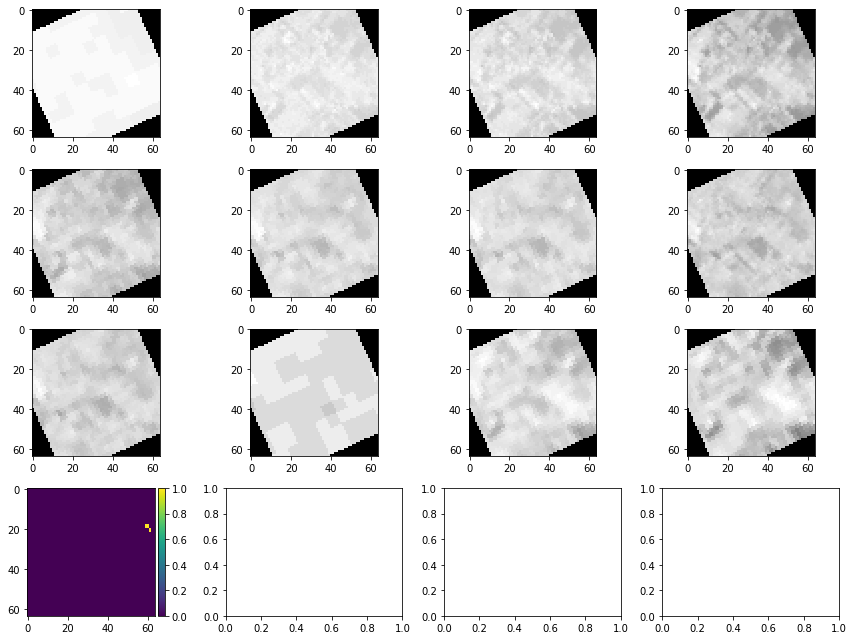

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(s*4, s*3))
print(labels[ind], crop_dict[labels[ind].item()])
for ax, img in zip(axes.ravel(), imgs[ind]):
  plt.sca(ax)
  im = img.numpy()
  im = im / np.max(im)
  io.imshow(im)

tensor(2) Mustard


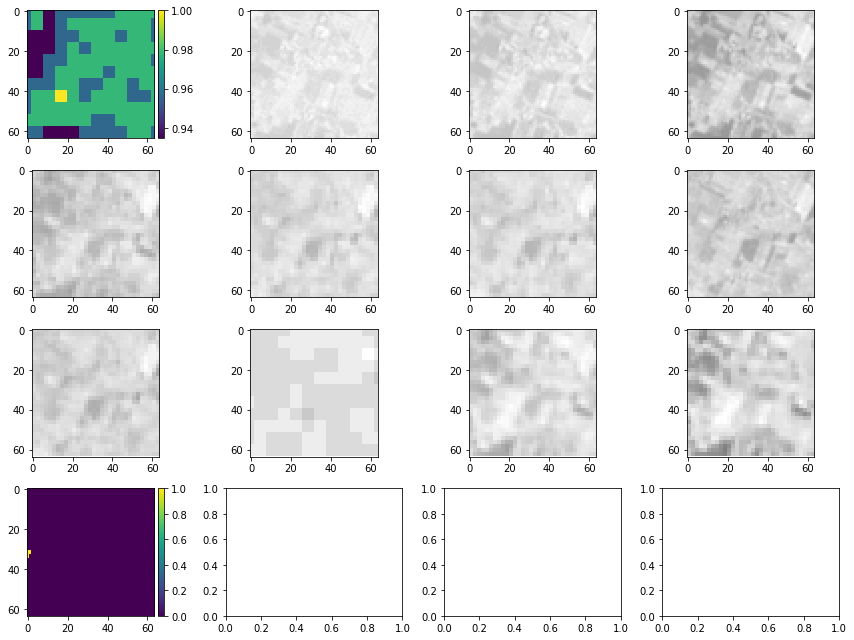

In [29]:
fig, axes = plt.subplots(4, 4, figsize=(s*4, s*3))
print(labels0[ind], crop_dict[labels0[ind].item()])
for ax, img in zip(axes.ravel(), imgs0[ind]):
  plt.sca(ax)
  im = img.numpy()
  im = im / np.max(im)
  io.imshow(im)

### Specify the loaders

In [30]:
np.random.seed(random_seed)

dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                transforms=train_transforms
                ), 
    shuffle=True, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(df_val, size=size,
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

## Specify the training pipeline

### Parameters

In [31]:
lr = 0.0001
weight_decay = 0.0005
epochs = 50

### Model and loss

In [32]:
net = models.efficientnet_b0()

In [33]:
from torchvision.ops.misc import Conv2dNormActivation

In [34]:
net.features[0] =  Conv2dNormActivation(
    len(BAND_NAMES) + 1, 32, kernel_size=3, stride=2, 
    norm_layer=nn.BatchNorm2d, activation_layer=nn.SiLU
    )
net.classifier[1] = nn.Linear(in_features=1280, 
                              out_features=int(crop_labels.max() + 1), 
                              bias=True)
net.cuda();

In [35]:
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(loss_weights).float()).cuda()

### Optimizer and scheduler

In [36]:
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
            )
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(dl_train), epochs=epochs
    )

### Training step

In [37]:
def train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler):
  net.train()
  loss_fn.train()
  epoch_loss = 0
  step = 0
  for imgs, targets, _ in tqdm(dl_train):
    step += 1
    optimizer.zero_grad()
    outputs = net(imgs.cuda())
    losses = loss_fn(outputs, targets.cuda())
    losses.backward()
    optimizer.step()
    epoch_loss += losses.item()
    lr_scheduler.step()
  epoch_loss /= step
  return epoch_loss

### Validation step

In [38]:
def validate_epoch(net, loss_fn, dl_val):
  net.eval()
  loss_fn.eval()
  epoch_loss = 0
  step = 0

  with torch.no_grad():
    for imgs, targets, _ in tqdm(dl_val):
      step += 1
      outputs = net(imgs.cuda())
      losses = loss_fn(outputs, targets.cuda())
      epoch_loss += losses.item()
  epoch_loss /= step
  return epoch_loss

## Train the model

In [39]:
%%time
torch.manual_seed(random_seed)
np.random.seed(random_seed)
best_loss = 10**10
train_losses = []
val_losses = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler)

    # validation pass
    val_loss = validate_epoch(net, loss_fn, dl_val)

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; "
          f"lr: {optimizer.param_groups[0]['lr']}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss <= best_loss:
      best_loss = val_loss
      torch.save(net.state_dict(), 'model.pth')
      print('saving best model')

100%|██████████| 10/10 [00:33<00:00,  3.36s/it]

epoch 1 training loss: 3.6521; validation loss: 3.6265; lr: 4.263423010947081e-06
saving best model
CPU times: user 6.69 s, sys: 1.7 s, total: 8.38 s
Wall time: 2min 50s


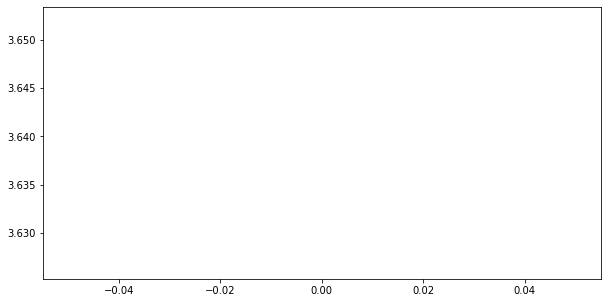

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

## Set up the loaders and model for evaluation

In [41]:
dl_test = torch.utils.data.DataLoader(
    AgriDataset(df_val),
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [42]:
net.load_state_dict(torch.load('model.pth'))
net.eval();

## Evaluate the model on the validation set

In [43]:
crop_columns = [crop_dict[key] for key in crop_labels]
crop_columns

['Wheat',
 'Mustard',
 'Lentil',
 'No Crop',
 'Green pea',
 'Sugarcane',
 'Garlic',
 'Maize',
 'Gram',
 'Coriander',
 'Potato',
 'Bersem',
 'Rice']

In [44]:
crop_labels

array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 13., 14., 15., 16., 36.])

In [45]:
def evaluate(dl_test, net, crop_labels, df_val):
  field_data = []
  outputs = []
  with torch.no_grad():
    for imgs, gt, field_id in tqdm(dl_test):
      output = net(imgs.cuda()).cpu().numpy()
      output = output[:, np.int_(crop_labels)]
      output = output - output.min(1).reshape(-1, 1)
      output = output / output.sum(1).reshape(-1, 1)
      field_id = field_id.numpy()
      field_data.append(field_id)
      outputs.append(output)
  outputs = np.concatenate(outputs, axis=0)
  outputs = outputs * df_val['field_area'].values.reshape(-1, 1)

  df_out = pd.DataFrame(outputs, columns=crop_labels)
  df_out['field_id'] = df_val['field_id']
  df_out['crop_type'] = df_val['crop_type']
  df_sm = df_out.groupby('field_id').sum().reset_index()
  df_sm[crop_labels] = df_sm[crop_labels].values / np.sum(df_sm[crop_labels].values, axis=1).reshape(-1,1)
        
  return df_sm[crop_labels].values, df_sm['field_id'].values, df_out.groupby('field_id').mean().reset_index()['crop_type'].values

In [46]:
probs, field_ids, gt = evaluate(dl_test, net, crop_labels, df_val)

100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


In [47]:
probs.shape, field_ids.shape, gt.shape

((1112, 13), (1112,), (1112,))

In [48]:
from sklearn.metrics import classification_report

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       406
         2.0       0.00      0.00      0.00       198
         3.0       0.00      0.00      0.00        21
         4.0       0.00      0.00      0.00       328
         5.0       0.00      0.00      0.00         5
         6.0       0.00      0.00      0.00        33
         8.0       0.00      0.00      0.00        10
         9.0       0.05      1.00      0.10        59
        13.0       0.00      0.00      0.00        12
        14.0       0.00      0.00      0.00         3
        15.0       0.00      0.00      0.00         8
        16.0       0.00      0.00      0.00         3
        36.0       0.00      0.00      0.00        26

    accuracy                           0.05      1112
   macro avg       0.00      0.08      0.01      1112
weighted avg       0.00      0.05      0.01      1112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
def to_one_hot(x):
    y = np.zeros((x.size, x.max() + 1))
    y[np.arange(x.size), x] = 1
    return y

def cross_entropy(predictions, targets):
    return -np.sum(np.sum(np.log(predictions + 10**(-10)) * targets, axis=1))/len(targets)


In [50]:
targets = to_one_hot(np.int_(gt))
targets = targets[:, np.where(targets.sum(axis=0) > 0)[0]]

In [51]:
cross_entropy(probs, targets)

8.60991947152237

## Prepare the test dataset

In [52]:
test_paths = os.listdir(os.path.join(data_dir, test_label_collection))
test_ids = [fn.split('_')[-1] for fn in test_paths if 'labels_test' in fn]

field_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' 
               for i in test_ids]
label_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/raster_labels.tif' 
               for i in test_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in test_ids]

In [53]:
test_data = pd.DataFrame(np.array([test_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
test_data.head()

,folder_id,field_path,label_path,source_path
0,f6b64,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
1,1dd2e,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
2,58bbf,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
3,c391d,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
4,72a8f,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...


In [58]:
def extract_field_crop_data_test(data):
  field_ids = []
  field_center_x = []
  field_center_y = []
  field_paths = []
  source_paths = []
  field_area = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          field_area.append(len(ind[0]))
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, field_center_x, 
                              field_center_y, field_area]).transpose(),
                    columns=['field_id', 'center_x', 'center_y', 'field_area'])
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [59]:
test_df = extract_field_crop_data_test(test_data)

100%|██████████| 707/707 [00:02<00:00, 268.59it/s]


## Evaluate the model on the test set

In [60]:
dl_test = torch.utils.data.DataLoader(
    AgriDataset(test_df), shuffle=False, batch_size=batch_size, num_workers=2
    )

In [62]:
test_df['crop_type'] = 1
probs, field_ids, _ = evaluate(dl_test, net, crop_labels, test_df)

100%|██████████| 13/13 [00:42<00:00,  3.26s/it]


In [63]:
def labeler(labeled):
    crop_label = np.array([crop_dict.get(f'{int(i)}') for i in labeled])
    return crop_label

In [64]:
crop_columns = [crop_dict[key] for key in crop_labels]

output_df  = pd.DataFrame(columns=['field_id'] + crop_columns)

output_df['field_id'] = field_ids

output_df[crop_columns] = probs 
output_df.to_csv('submission.csv', index=False)

In [65]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>